In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import pandas

In [0]:
def get_data():
    header = ['tweet','label']
    data_set = pandas.read_csv('cleaned_data.txt',delimiter='\t',names = header)
    return data_set

def split_tweet(tweet):
    return tweet.split()    


In [0]:
data_set = get_data()

In [9]:
glove = torchtext.vocab.GloVe(name="twitter.27B",dim=50)

# inser padding character into glove embedding, we overwrite the first element and that's okay
# because we don't use the first element in our vocab
glove.vectors[0] = torch.tensor(np.zeros(50))

.vector_cache/glove.twitter.27B.zip: 1.52GB [09:03, 2.80MB/s]                            
100%|█████████▉| 1190439/1193514 [00:35<00:00, 33212.45it/s]

In [10]:
len(data_set)

320928

In [11]:
data_set

,tweet,label
0,hoping i dont screw up this interview,0
1,i feel like a baby kangaroo stuck in its mothe...,1
2,girl ppl should be happy i even remembered her...,0
3,"oh , the irony if misha wins the choice tv sc...",2
4,"i miss you to , you so fake now",2
5,"i miss you to , you so fake now",4
6,i know,1
7,bacolod please ? !,0
8,things can change so quickly,1
9,all me &amp ; vic do is laugh . . anybody o...,1


In [0]:
def data_set_to_glove_index(glove_dict):
    tweets_ints, encoded_labels = [],[]
    for i in range(len(data_set)):
        tweet = data_set['tweet'][i]
        label = data_set['label'][i]
        if(type(tweet) != str):
            continue
        idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
        if not idxs: # ignore tweets without any word with an embedding
            continue
        tweets_ints.append(idxs)
        encoded_labels.append(label)
    return tweets_ints, encoded_labels

In [0]:
tweets_ints, encoded_labels = data_set_to_glove_index(glove)

In [14]:
from collections import Counter
# outlier review stats
tweets_lens = Counter([len(x) for x in tweets_ints])
print("Zero-length tweets: {}".format(tweets_lens[0]))
print("Maximum tweet length: {}".format(max(tweets_lens)))

Zero-length tweets: 0
Maximum tweet length: 62


In [0]:
def pad_features(tweets_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's 
        or truncated to the input seq_length.
    '''
    
    # getting the correct rows x cols shape
    features = np.zeros((len(tweets_ints), seq_length), dtype=int)

    # for each review, I grab that review and 
    for i, row in enumerate(tweets_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features

In [0]:
seq_length = max(tweets_lens)

features = pad_features(tweets_ints, seq_length=seq_length)
encoded_labels = np.array(encoded_labels)

In [17]:
print(features[:30,])

[[    0     0     0 ...    85    53  2706]
 [    0     0     0 ...   221  9193 50306]
 [    0     0     0 ...   316   226   325]
 ...
 [    0     0     0 ...    13  1863   328]
 [    0     0     0 ... 58381  1465     1]
 [    0     0     0 ...  1104    96  4799]]


### Train, Validation, Test Split

In [0]:
from sklearn.utils import shuffle
features, encoded_labels = shuffle(features, encoded_labels)

In [19]:
split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = encoded_labels[:split_idx], encoded_labels[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(255615, 62) 
Validation set: 	(31952, 62) 
Test set: 		(31952, 62)


### DataLoader and Batching

In [0]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 50

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size,drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,drop_last=True)

In [21]:
len(train_loader)

5112

### Building the model

In [0]:
class TweetLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, use_gpu):
        super(TweetLSTM, self).__init__()
        self.use_gpu = use_gpu
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size,bidirectional=True,batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes) # 2 * hidden_size because LSTM is bidrectional 
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state and cell state
        
        if self.use_gpu:
          h0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
          c0 = torch.zeros(2, x.size(0), self.hidden_size).cuda()
        else:
          h0 = torch.zeros(2, x.size(0), self.hidden_size)
          c0 = torch.zeros(2, x.size(0), self.hidden_size)
        # Forward propagate the LSTM
        out, _ = self.rnn(x, (h0, c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out
num_classes = 6
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes,use_gpu=True)

In [23]:
def get_accuracy(model, data_loader, use_gpu):
    if use_gpu:
      model.cuda()
    correct, total = 0, 0
    for tweets, labels in data_loader:
        if use_gpu:
          tweets,labels  = tweets.cuda(), labels.cuda()
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return float(correct) / float(total)
  

get_accuracy(model, test_loader,use_gpu = True)


0.17517996870109545

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5,use_gpu=True):
    if use_gpu:
      model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses,valid_losses, train_acc, valid_acc = [], [], [],[]
    epochs = []
    counter = 0
    for epoch in range(num_epochs):
        batch_loss_train = []
        for tweets, labels in train:
            if use_gpu:
              tweets,labels  = tweets.cuda(), labels.cuda()
            counter += 1
            optimizer.zero_grad()
            pred = model(tweets)
            train_loss = criterion(pred, labels)
            train_loss.backward()
            optimizer.step()
            batch_loss_train.append(float(train_loss))
            if counter % 100 == 0:
              print("Step %d of Epoch: %d; Loss %f " % ( counter/100 ,epoch+1,np.mean(batch_loss_train)))
        counter = 0
        epoch_loss = np.mean(batch_loss_train)
        train_losses.append(epoch_loss)
        
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader,use_gpu))
        
        print("Final Result for Epoch %d: Train Loss %f; Train Acc %f" % (
              epoch+1, epoch_loss, train_acc[-1]))
        
        
        batch_loss_valid = []
        for tweets,labels in valid:
          if use_gpu:
            tweets,labels  = tweets.cuda(), labels.cuda()
          counter += 1
          pred_valid = model(tweets)
          valid_loss = criterion(pred_valid, labels)
          batch_loss_valid.append(float(valid_loss))
          if counter % 100 == 0:
              print("Step %d of Epoch: %d; Loss %f " % ( counter/100 ,epoch+1,np.mean(batch_loss_valid)))
        counter = 0
        epoch_loss_valid = np.mean(batch_loss_valid)
        valid_losses.append(epoch_loss_valid)
        valid_acc.append(get_accuracy(model, valid_loader,use_gpu))
        
        print("Final Result for Epoch %d: Valid Loss %f; Valid Acc %f" % (
              epoch+1, epoch_loss_valid, valid_acc[-1]))
        
        print("-------------------------------------------------------------")
        
    # plotting
    plt.title("Loss Curve")
    plt.plot(epochs,train_losses, label="Train")
    plt.plot(epochs,valid_losses, label="Valid")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Accuracy Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Step 1 of Epoch: 1; Loss 1.775083 
Step 2 of Epoch: 1; Loss 1.759571 
Step 3 of Epoch: 1; Loss 1.749771 
Step 4 of Epoch: 1; Loss 1.745262 
Step 5 of Epoch: 1; Loss 1.739507 
Step 6 of Epoch: 1; Loss 1.735358 
Step 7 of Epoch: 1; Loss 1.732506 
Step 8 of Epoch: 1; Loss 1.730072 
Step 9 of Epoch: 1; Loss 1.727696 
Step 10 of Epoch: 1; Loss 1.725257 
Step 11 of Epoch: 1; Loss 1.723319 
Step 12 of Epoch: 1; Loss 1.721414 
Step 13 of Epoch: 1; Loss 1.719379 
Step 14 of Epoch: 1; Loss 1.718124 
Step 15 of Epoch: 1; Loss 1.716930 
Step 16 of Epoch: 1; Loss 1.715732 
Step 17 of Epoch: 1; Loss 1.713862 
Step 18 of Epoch: 1; Loss 1.711926 
Step 19 of Epoch: 1; Loss 1.710368 
Step 20 of Epoch: 1; Loss 1.709669 
Step 21 of Epoch: 1; Loss 1.708494 
Step 22 of Epoch: 1; Loss 1.707540 
Step 23 of Epoch: 1; Loss 1.706715 
Step 24 of Epoch: 1; Loss 1.705783 
Step 25 of Epoch: 1; Loss 1.705106 
Step 26 of Epoch: 1; Loss 1.704353 
Step 27 of Epoch: 1; Loss 1.703415 
Step 28 of Epoch: 1; Loss 1.702301 
S

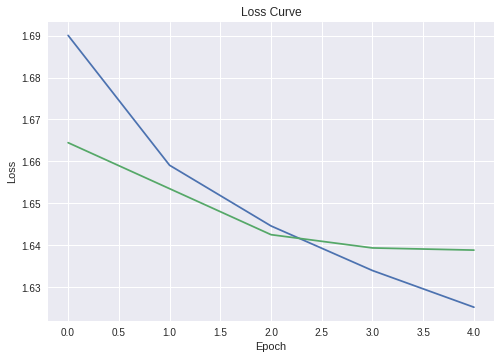

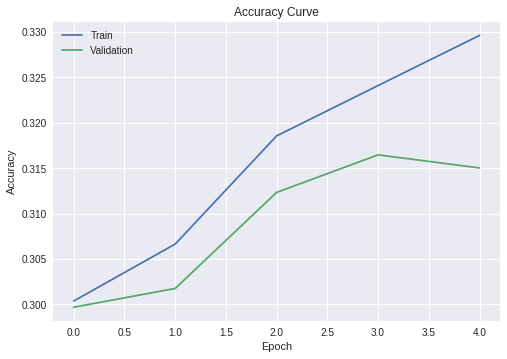

total training time: 363 s


In [36]:
import time
start = time.time()
model = TweetLSTM(input_size=50, hidden_size=50, num_classes=num_classes,use_gpu=True)
train_rnn_network(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-3,use_gpu=True)
end = time.time()
print("total training time:", int(end -start), "s")

### Saving the model

In [37]:
# saving the model to the google drive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# saving the model to the google drive
torch.save(model.state_dict(), '/content/gdrive/My Drive/checkpoint_biLSTM_5epochs.pth')

### Loading the model

In [0]:
state_dict = torch.load('/content/gdrive/My Drive/checkpoint_biLSTM.pth')

In [0]:
model.load_state_dict(state_dict)

### Inference

In [0]:
# Tweet Test
happy_tweet = 'Im happy'
sad_tweet = 'Im sad'
angry = 'Im angry'
surprised_tweet = 'Im surprised'
disgusted_tweet = 'Im disgusted'
afraid_tweet = 'Im afraid'

In [0]:
def tweet_to_glove_index(tweet,glove_dict):
    tweets_ints = []
    tweet = tweet.lower()
    idxs = [glove_dict.stoi[w]        # lookup the index of word
            for w in tweet.split()
            if w in glove_dict.stoi] # keep words that has an embedding
    tweets_ints.append(idxs)
    return tweets_ints

In [0]:
int_to_emotion = {0:'Happy', 1:'Sad' , 2:'Angry', 3:'Surprised', 4:'Disgusted', 5:'Afraid'}

def predict(model, test_tweet, sequence_length=max(tweets_lens),use_gpu=True):
    
    
    # tokenize tweet
    test_ints = tweet_to_glove_index(test_tweet,glove)
    
    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # convert to tensor to pass into your model
    if use_gpu:
      feature_tensor = torch.from_numpy(features).cuda()
    else:
      feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    
    # get the output from the model
    output = model(feature_tensor)
    
    # convert output probabilities to predicted class (0 or 1)
    output_prob = nn.functional.softmax(output,dim=1)
    top_n_pred = output_prob.topk(3,dim=1) ## top 3 preds
    top_n_pred_prob, top_n_pred_index = top_n_pred[0].detach().cpu().numpy()[0], top_n_pred[1].detach().cpu().numpy()[0]
    print(test_tweet)
    print('Prediction:')
    for prob,index in zip(top_n_pred_prob,top_n_pred_index):
      print(int_to_emotion[index] , 'with' , str(int(prob*100))+"%", 'confidence')
    print('---------------')

In [42]:
predict(model,happy_tweet)
predict(model,sad_tweet)
predict(model,angry)
predict(model,surprised_tweet)
predict(model,disgusted_tweet)
predict(model,afraid_tweet)

Im happy
Prediction:
Happy with 62% confidence
Angry with 13% confidence
Afraid with 7% confidence
---------------
Im sad
Prediction:
Sad with 67% confidence
Disgusted with 13% confidence
Angry with 6% confidence
---------------
Im angry
Prediction:
Angry with 26% confidence
Disgusted with 23% confidence
Sad with 15% confidence
---------------
Im surprised
Prediction:
Surprised with 24% confidence
Afraid with 23% confidence
Happy with 18% confidence
---------------
Im disgusted
Prediction:
Disgusted with 40% confidence
Sad with 27% confidence
Angry with 11% confidence
---------------
Im afraid
Prediction:
Sad with 24% confidence
Surprised with 24% confidence
Afraid with 20% confidence
---------------


In [0]:
tweets = ['Im so happy',
          'I feel so down today',
          'It boils my blood to see you',
         'wow what a nice car',
         'im sick of this shit',
         'theres a stranger at my home']

In [44]:
for tweet in tweets:
  predict(model, tweet)

Im so happy
Prediction:
Happy with 56% confidence
Sad with 15% confidence
Surprised with 8% confidence
---------------
I feel so down today
Prediction:
Sad with 44% confidence
Disgusted with 16% confidence
Angry with 12% confidence
---------------
It boils my blood to see you
Prediction:
Disgusted with 19% confidence
Surprised with 19% confidence
Angry with 17% confidence
---------------
wow what a nice car
Prediction:
Afraid with 43% confidence
Surprised with 35% confidence
Happy with 8% confidence
---------------
im sick of this shit
Prediction:
Disgusted with 38% confidence
Sad with 25% confidence
Angry with 21% confidence
---------------
theres a stranger at my home
Prediction:
Surprised with 40% confidence
Afraid with 22% confidence
Happy with 9% confidence
---------------
